In [28]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv("train.csv")
features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")

# Preview the shapes and first rows
print("Train shape:", train_df.shape)
print("Features shape:", features_df.shape)
print("Stores shape:", stores_df.shape)

train_df.head()

Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [29]:
# Merge train with features on ['Store', 'Date']
train_features_df = pd.merge(train_df, features_df, how='left', on=['Store', 'Date'])

# Now merge with stores on 'Store'
full_df = pd.merge(train_features_df, stores_df, how='left', on='Store')

# Check shape and preview
print("Final merged shape:", full_df.shape)
full_df.head()


Final merged shape: (421570, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [30]:
# Check missing values
missing = full_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("Columns with missing values:\n")
print(missing)


Columns with missing values:

MarkDown2    310322
MarkDown4    286603
MarkDown3    284479
MarkDown1    270889
MarkDown5    270138
dtype: int64


In [31]:
# List of columns that have missing values
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Replace all missing values in these columns with 0
full_df[markdown_cols] = full_df[markdown_cols].fillna(0)

# Check if any missing values are left in the whole dataset
print("Any missing left?", full_df.isnull().sum().sum())


Any missing left? 0


In [32]:
# Rename IsHoliday_y to IsHoliday
full_df.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)

# Drop the other one
full_df.drop(columns=['IsHoliday_x'], inplace=True)


In [33]:
# Convert 'Date' column to datetime format
full_df['Date'] = pd.to_datetime(full_df['Date'])

# Extract date features
full_df['Year'] = full_df['Date'].dt.year
full_df['Month'] = full_df['Date'].dt.month
full_df['Week'] = full_df['Date'].dt.isocalendar().week
full_df['Day'] = full_df['Date'].dt.day
full_df['DayOfWeek'] = full_df['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Convert IsHoliday from True/False to 0/1
full_df['IsHoliday'] = full_df['IsHoliday'].astype(int)

# Check result
full_df[['Date', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'IsHoliday']].head()


,Date,Year,Month,Week,Day,DayOfWeek,IsHoliday
0,2010-02-05,2010,2,5,5,4,0
1,2010-02-12,2010,2,6,12,4,1
2,2010-02-19,2010,2,7,19,4,0
3,2010-02-26,2010,2,8,26,4,0
4,2010-03-05,2010,3,9,5,4,0


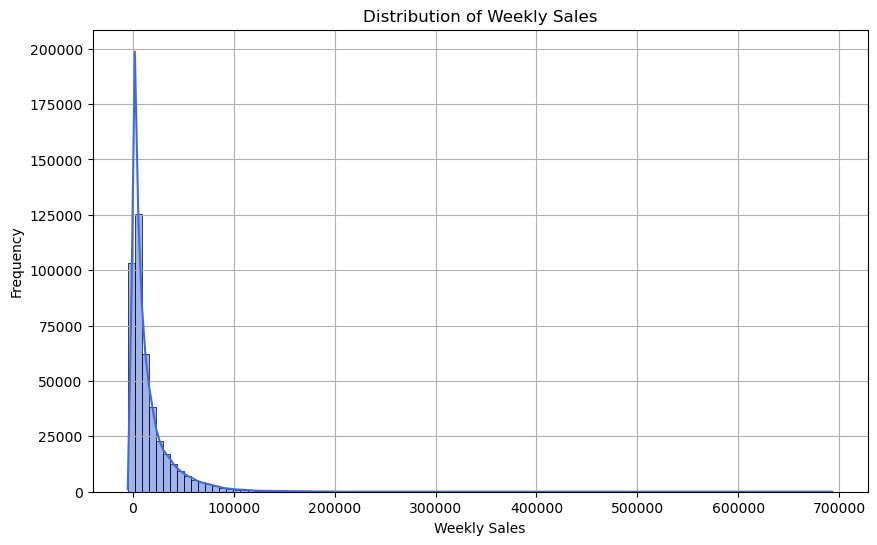

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(full_df['Weekly_Sales'], bins=100, kde=True, color='royalblue')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

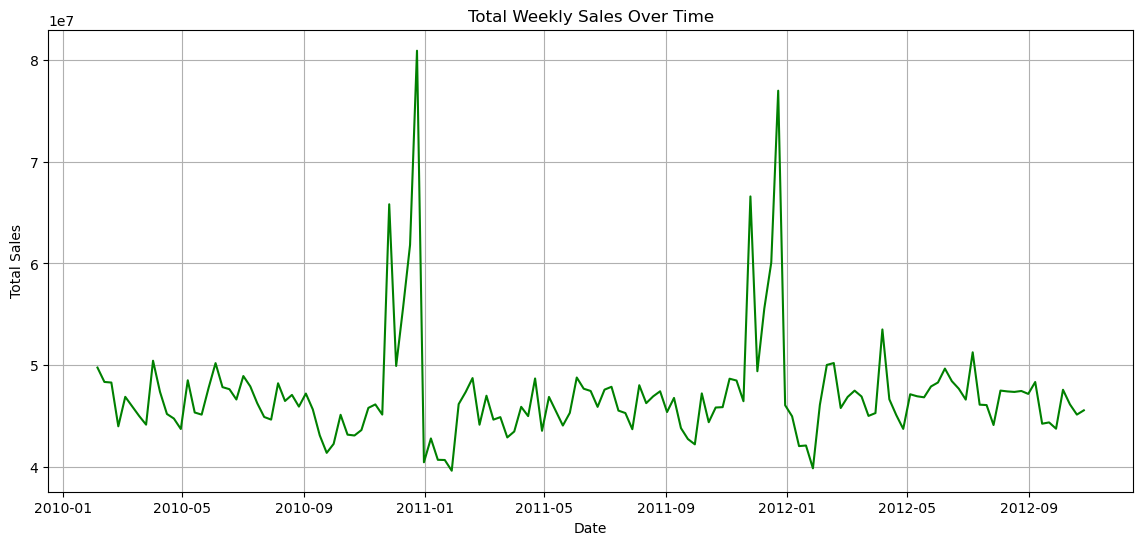

In [35]:
# Group total sales by date
daily_sales = full_df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Plot sales trend over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='Date', y='Weekly_Sales', color='green')
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


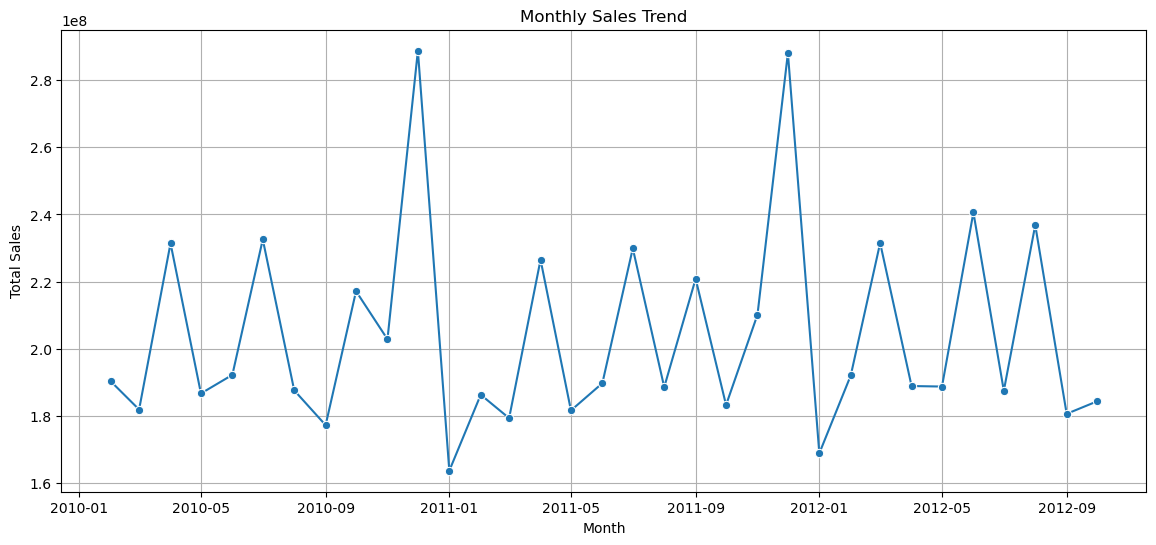

In [36]:
monthly_sales = full_df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()

# Combine year and month for better plotting
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(DAY=1))

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales, x='YearMonth', y='Weekly_Sales', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


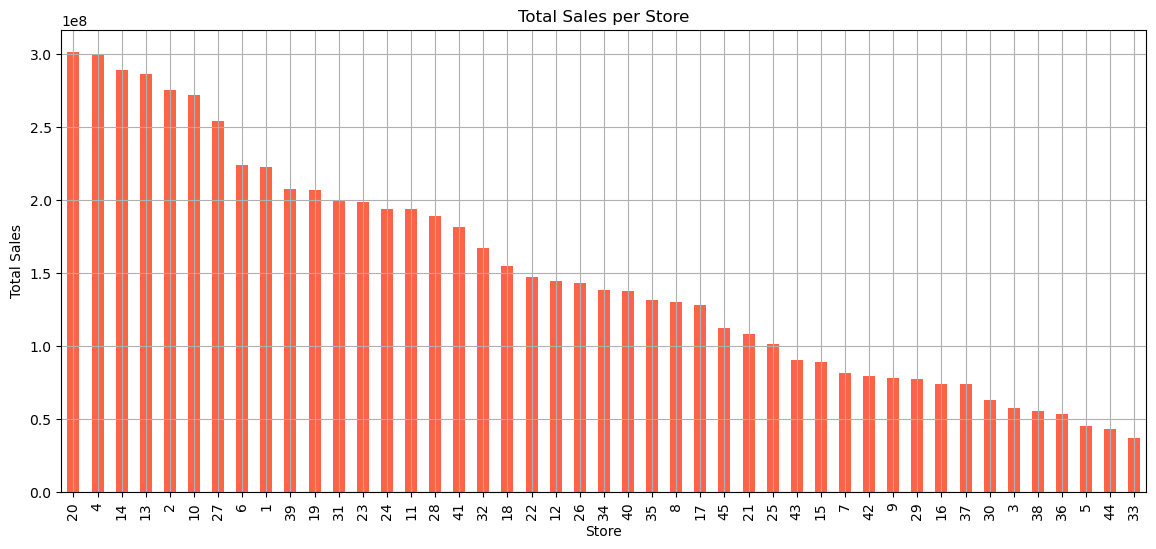

In [37]:
store_sales = full_df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
store_sales.plot(kind='bar', color='tomato')
plt.title('Total Sales per Store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


In [38]:
X = full_df.drop(columns=['Date', 'Weekly_Sales'])  # Features
y = full_df['Weekly_Sales']                         # Target


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
full_df.dtypes


Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                int32
Type                    object
Size                     int64
Year                     int32
Month                    int32
Week                    UInt32
Day                      int32
DayOfWeek                int32
dtype: object

In [41]:
full_df_encoded = pd.get_dummies(full_df, columns=['Type', 'IsHoliday'], drop_first=True)


In [42]:
X = full_df_encoded.drop(columns=['Date', 'Weekly_Sales'])
y = full_df_encoded['Weekly_Sales']

# Split again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
full_df.dtypes


Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                int32
Type                    object
Size                     int64
Year                     int32
Month                    int32
Week                    UInt32
Day                      int32
DayOfWeek                int32
dtype: object

In [44]:
# One-hot encode 'Type' column
full_df_encoded = pd.get_dummies(full_df, columns=['Type'], drop_first=True)


In [45]:
# Drop Date and Weekly_Sales
X = full_df_encoded.drop(columns=['Date', 'Weekly_Sales'])
y = full_df_encoded['Weekly_Sales']


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [48]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"✅ R² Score: {r2}")
print(f"✅ RMSE: {rmse}")


✅ R² Score: 0.0926424941888544
✅ RMSE: 21752.25550260077


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


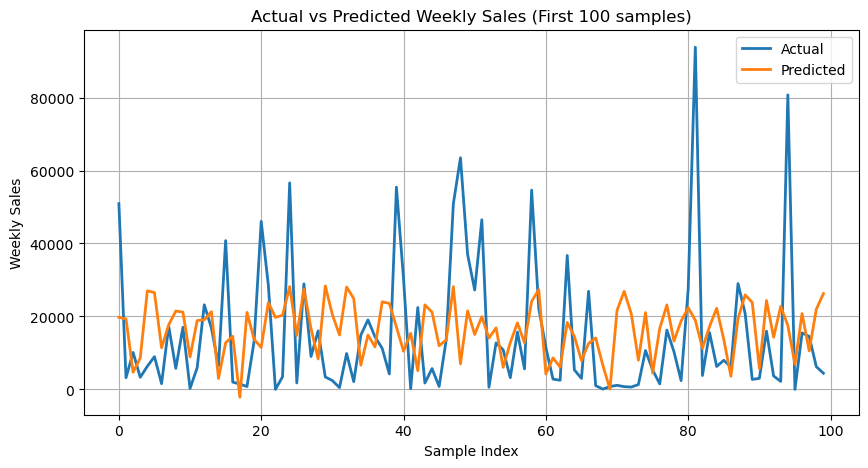

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual', linewidth=2)
plt.plot(y_pred[:100], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Weekly Sales (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

print(f"🌲 RF R² Score: {r2_rf:.4f}")
print(f"🌲 RF RMSE: {rmse_rf:.2f}")


🌲 RF R² Score: 0.8822
🌲 RF RMSE: 7838.68


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\Dell\AppData\Local\Temp\ipykernel_8800\593756255.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


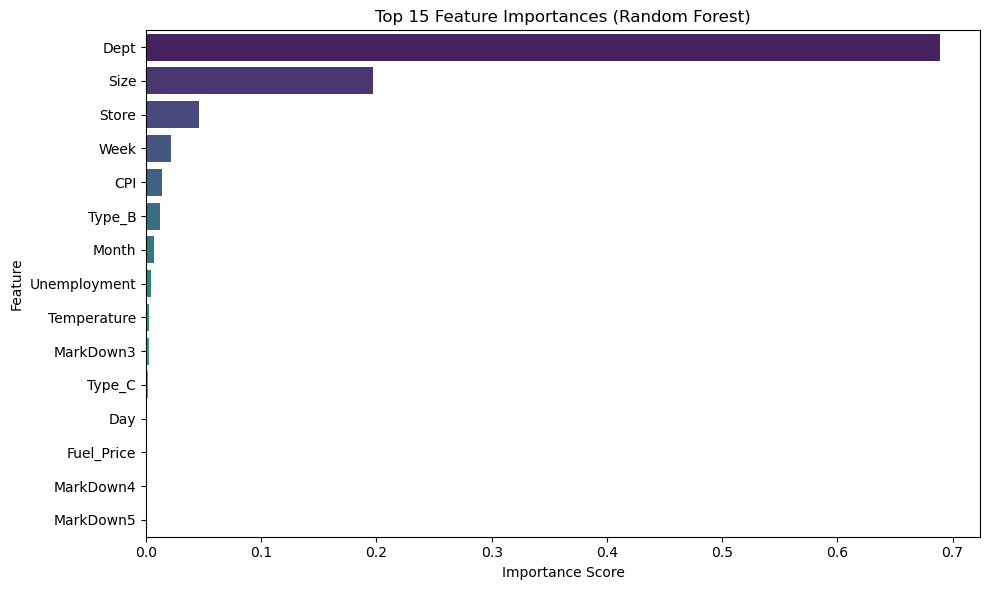

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get feature importances
importances = rf_model.feature_importances_

# Step 2: Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Step 3: Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [52]:
import joblib

# Save the trained model
joblib.dump(rf_model, "random_forest_sales_model.joblib")


['random_forest_sales_model.joblib']

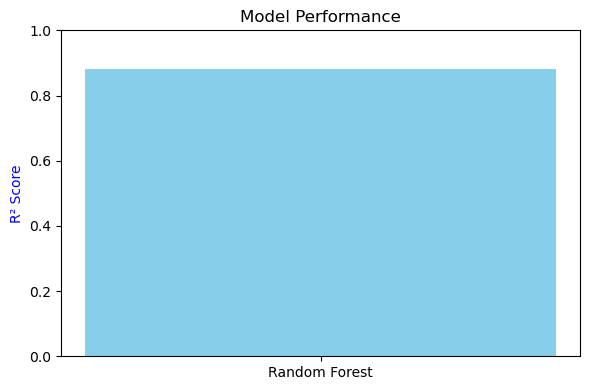

In [53]:
import matplotlib.pyplot as plt

models = ['Random Forest']
r2_scores = [r2_rf]
rmses = [rmse_rf]

fig, ax1 = plt.subplots(figsize=(6, 4))

# R² Score Bar
ax1.bar(models, r2_scores, color='skyblue')
ax1.set_ylabel("R² Score", color='blue')
ax1.set_ylim(0, 1)

plt.title("Model Performance")
plt.tight_layout()
plt.show()
